# Importing needful libraries

In [10]:
import torch
from pathlib import Path
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import os, shutil, yaml



# Verify Dataset

In [6]:
# Verify dataset structure
print("\n" + "=" * 60)
print("DATASET VERIFICATION")
print("=" * 60)

dataset_path = Path('dataset')
images_path = dataset_path / 'images'
labels_path = dataset_path / 'labels'

# Count files
image_files = list(images_path.glob('*.[jJ][pP][gG]')) + \
              list(images_path.glob('*.[pP][nN][gG]')) + \
              list(images_path.glob('*.[jJ][pP][eE][gG]'))
label_files = list(labels_path.glob('*.txt'))

# Remove classes.txt from count
label_files = [f for f in label_files if f.name != 'classes.txt']

print(f"Images found: {len(image_files)}")
print(f"Labels found: {len(label_files)}")

if len(image_files) == 0:
    print("\nWARNING: No images found! Please add images to dataset/images/")
elif len(label_files) == 0:
    print("\nWARNING: No labels found! Please annotate images using labelImg")
elif len(image_files) != len(label_files):
    print(f"\nWARNING: Mismatch! {len(image_files)} images but {len(label_files)} labels")
    print("Some images might not be annotated yet.")
else:
    print("\nDataset looks good!")


DATASET VERIFICATION
Images found: 30
Labels found: 0



In [7]:
import ultralytics
print(ultralytics.__version__)


8.3.203


In [18]:
# Change to dataset directory
import os
os.chdir('/Users/sulaknaweerasinghe/Documents/AI Projects/ YOLO')
print(f"Changed to: {os.getcwd()}")

Changed to: /Users/sulaknaweerasinghe/Documents/AI Projects/ YOLO


✓ Libraries imported

📄 Dataset Configuration:
   Classes: 3
   Names: ['Cutlet', 'dhal wade', 'objects']

📊 Dataset Summary:
   Train: 20 images, 20 labels
   Valid: 10 images, 10 labels
   Test:  5 images

✓ Dataset structure verified!


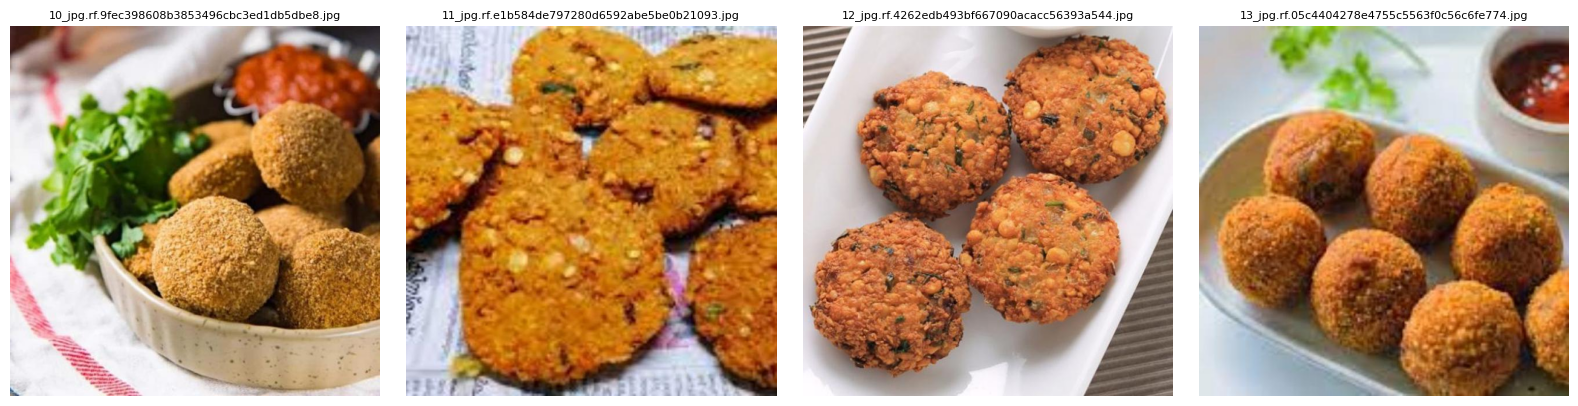

In [23]:
# Set base path to dataset folder
BASE_PATH = 'dataset'

print("✓ Libraries imported\n")

# Verify data.yaml
with open(f'{BASE_PATH}/data.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("📄 Dataset Configuration:")
print(f"   Classes: {config['nc']}")
print(f"   Names: {config['names']}\n")

# Count files
def count_files(dir, ext):
    return len([f for f in os.listdir(dir) if f.endswith(ext)]) if os.path.exists(dir) else 0

train_img = count_files(f'{BASE_PATH}/train/images', ('.jpg', '.jpeg', '.png'))
train_lbl = count_files(f'{BASE_PATH}/train/labels', '.txt')
valid_img = count_files(f'{BASE_PATH}/valid/images', ('.jpg', '.jpeg', '.png'))
valid_lbl = count_files(f'{BASE_PATH}/valid/labels', '.txt')
test_img = count_files(f'{BASE_PATH}/test', ('.jpg', '.jpeg', '.png'))

print("📊 Dataset Summary:")
print(f"   Train: {train_img} images, {train_lbl} labels")
print(f"   Valid: {valid_img} images, {valid_lbl} labels")
print(f"   Test:  {test_img} images\n")

if train_img == train_lbl and valid_img == valid_lbl:
    print("✓ Dataset structure verified!")
else:
    print("⚠ Warning: Image/label mismatch")

# Visualize samples
sample_imgs = sorted(os.listdir(f'{BASE_PATH}/train/images'))[:4]
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for idx, img_name in enumerate(sample_imgs):
    img = Image.open(f'{BASE_PATH}/train/images/{img_name}')
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(img_name, fontsize=8)
plt.tight_layout()
plt.show()


## 2. Model Training

Training YOLOv8n on the annotated dataset.

**Configuration:**
- Model: YOLOv8n (nano)
- Epochs: 50
- Image Size: 640x640
- Batch Size: 16
- Device: CPU (change to `0` for GPU or `'mps'` for Apple Silicon)

Starting training...

New https://pypi.org/project/ultralytics/8.3.204 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.203 🚀 Python-3.11.3 torch-2.8.0 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=cutlet_dhalwade_detector, nbs=64, nms=False, op

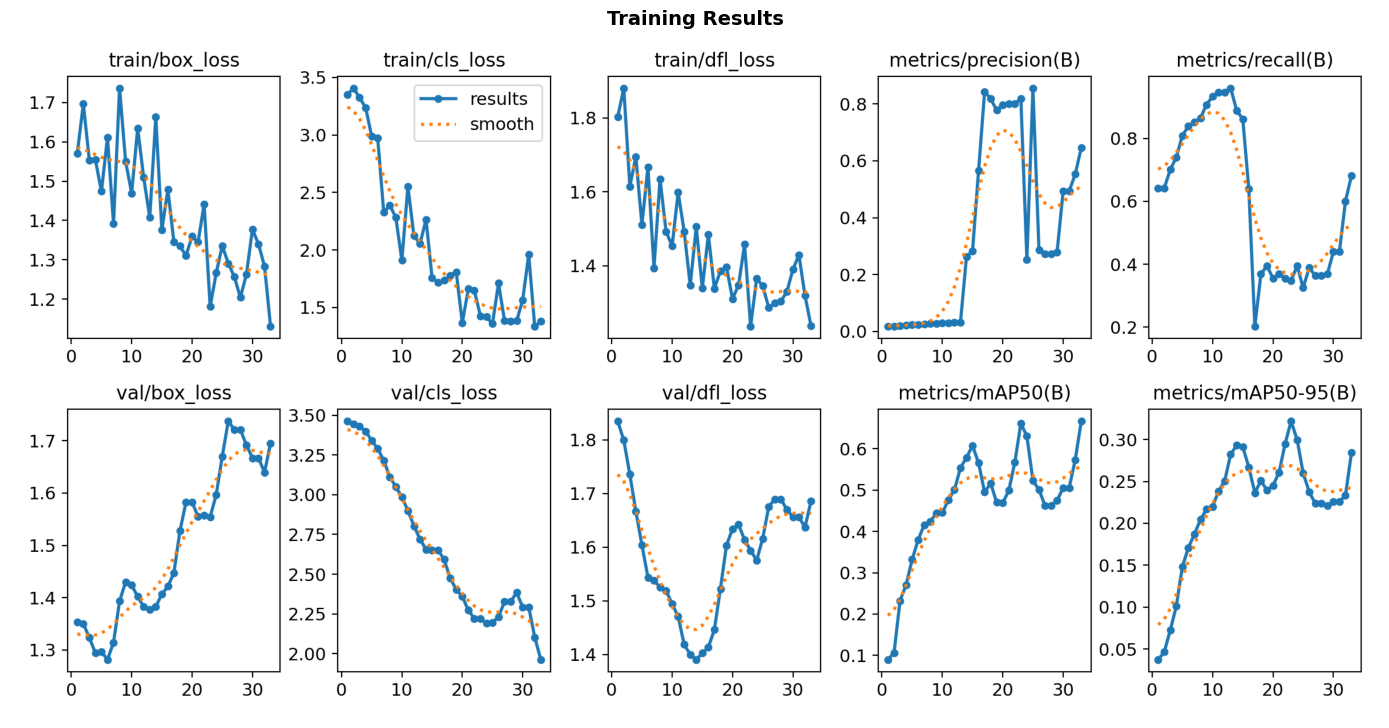

In [24]:
# Load model and train
model = YOLO('yolov8n.pt')

print("Starting training...\n")
results = model.train(
    data=f'{BASE_PATH}/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='cutlet_dhalwade_detector',
    patience=10,
    device='cpu',  # Change to 0 for GPU, 'mps' for Apple Silicon
    plots=True,
    exist_ok=True
)

print("\n✓ Training completed!")

# Validate model
metrics = model.val()

print(f"\n📈 Validation Results:")
print(f"   mAP50:     {metrics.box.map50:.4f}")
print(f"   mAP50-95:  {metrics.box.map:.4f}")
print(f"   Precision: {metrics.box.mp:.4f}")
print(f"   Recall:    {metrics.box.mr:.4f}")

# Save metrics
metrics_dict = {
    'mAP50': f'{metrics.box.map50:.4f}',
    'mAP50-95': f'{metrics.box.map:.4f}',
    'Precision': f'{metrics.box.mp:.4f}',
    'Recall': f'{metrics.box.mr:.4f}'
}

# Display training results
results_img = 'runs/detect/cutlet_dhalwade_detector/results.png'
if os.path.exists(results_img):
    img = Image.open(results_img)
    plt.figure(figsize=(14, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Training Results', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 3. Model Inference

Running predictions on test images.

Running inference on 5 test images...

[1/5] 12_jpg.rf.fe5822c1cd816ff92cacc33d36978377.jpg

image 1/1 /Users/sulaknaweerasinghe/Documents/AI Projects/ YOLO/dataset/test/12_jpg.rf.fe5822c1cd816ff92cacc33d36978377.jpg: 640x640 1 Cutlet, 80.1ms
Speed: 1.6ms preprocess, 80.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /Users/sulaknaweerasinghe/Documents/AI Projects/ YOLO/inference_results/predictions
    → 1 objects detected

[2/5] 2_jpg.rf.19ad3c49c83b8e59f030d90568b6166b.jpg

image 1/1 /Users/sulaknaweerasinghe/Documents/AI Projects/ YOLO/dataset/test/2_jpg.rf.19ad3c49c83b8e59f030d90568b6166b.jpg: 640x640 2 Cutlets, 71.4ms
Speed: 1.1ms preprocess, 71.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /Users/sulaknaweerasinghe/Documents/AI Projects/ YOLO/inference_results/predictions
    → 2 objects detected

[3/5] 5686_jpg.rf.4b0a14a8a7400a9b4af7a31a5f01bf08.jpg

image 1/1 /Users/sulaknaweerasinghe/Documents/AI P

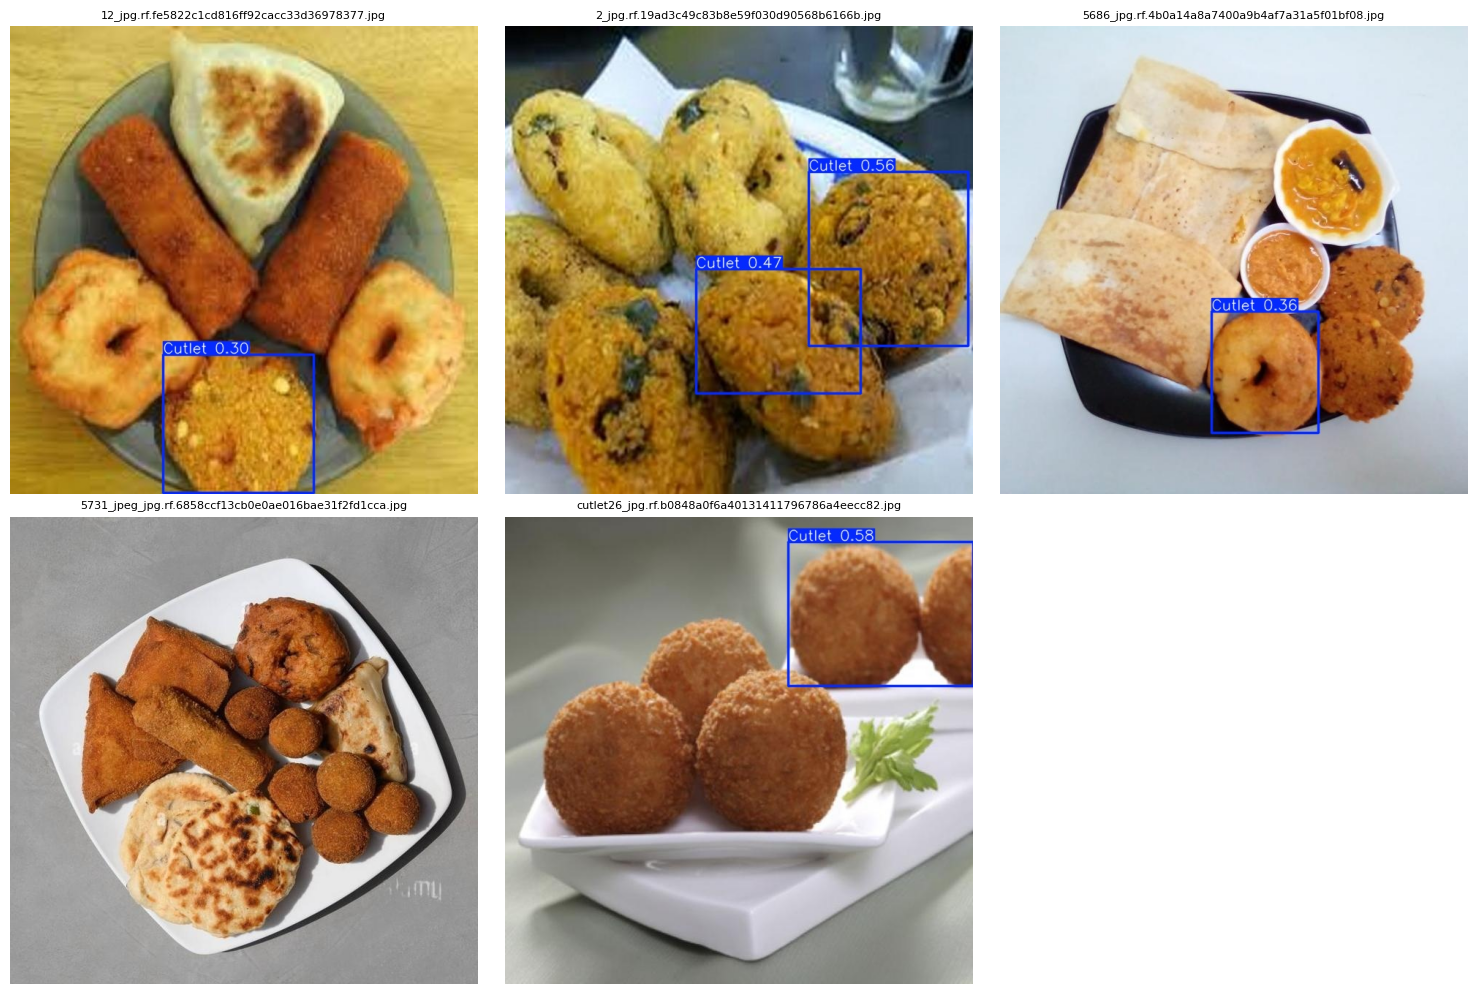

In [25]:
# Load best model
best_model = YOLO('runs/detect/cutlet_dhalwade_detector/weights/best.pt')

# Run inference
output_dir = 'inference_results'
test_images = sorted([f for f in os.listdir(f'{BASE_PATH}/test') if f.endswith(('.jpg', '.jpeg', '.png'))])

print(f"Running inference on {len(test_images)} test images...\n")

prediction_results = []
for i, img_name in enumerate(test_images, 1):
    print(f"[{i}/{len(test_images)}] {img_name}")
    results = best_model.predict(
        source=f'{BASE_PATH}/test/{img_name}',
        save=True,
        conf=0.25,
        project=output_dir,
        name='predictions',
        exist_ok=True
    )
    num_det = len(results[0].boxes)
    prediction_results.append((img_name, num_det))
    print(f"    → {num_det} objects detected\n")

print(f"✓ Outputs saved to: {output_dir}/predictions/")

# Display predictions
pred_dir = f'{output_dir}/predictions'
pred_images = sorted([f for f in os.listdir(pred_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

num_imgs = len(pred_images)
cols = 3
rows = (num_imgs + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
if rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, img_name in enumerate(pred_images):
    img = Image.open(f'{pred_dir}/{img_name}')
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(img_name, fontsize=8)

for idx in range(num_imgs, rows * cols):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 4. Output Structure & Submission

Organizing deliverables and generating documentation.

In [26]:
submission_dir = 'submission'
os.makedirs(submission_dir, exist_ok=True)

# Copy inference outputs
inf_out_dir = f'{submission_dir}/inference_outputs'
os.makedirs(inf_out_dir, exist_ok=True)

for idx, img_name in enumerate(pred_images, 1):
    shutil.copy(f'{pred_dir}/{img_name}', f'{inf_out_dir}/output_{idx}.jpg')

print(f"✓ Copied {len(pred_images)} inference outputs")

# Copy model
model_dir = f'{submission_dir}/trained_model'
os.makedirs(model_dir, exist_ok=True)
shutil.copy('runs/detect/cutlet_dhalwade_detector/weights/best.pt', f'{model_dir}/best.pt')
print("✓ Copied trained model")

# Copy training results
results_dir = f'{submission_dir}/training_results'
os.makedirs(results_dir, exist_ok=True)
if os.path.exists(results_img):
    shutil.copy(results_img, f'{results_dir}/results.png')
    print("✓ Copied training visualizations")

✓ Copied 5 inference outputs
✓ Copied trained model
✓ Copied training visualizations


In [27]:
# Generate README
readme = f"""# Cutlet & Dhal Wade Detection - YOLO Training Task

## Dataset Summary
- **Total Images**: {train_img + valid_img + test_img}
- **Classes**: 3 (Cutlet, Dhal Wade, Objects)
- **Split**: Train: {train_img}, Valid: {valid_img}, Test: {test_img}
- **Format**: YOLO format
- **Annotation Tool**: Roboflow

## Approach & Methodology

This project represents my first experience with image annotation for object detection. The workflow followed was:

1. **Image Annotation**: Used Roboflow platform to annotate all images with bounding boxes
2. **Dataset Export**: Exported annotations in YOLO format from Roboflow
3. **Local Development**: Downloaded the dataset and trained the model locally using YOLOv8
4. **Model Training**: Utilized pretrained YOLOv8n weights and fine-tuned on the custom dataset

As this is my first annotation project, there is room for improvement in annotation consistency and accuracy.

## Training Configuration
- **Model**: YOLOv8n
- **Epochs**: 50
- **Image Size**: 640x640
- **Batch Size**: 16
- **Device**: CPU

## Results
- **mAP50**: {metrics_dict['mAP50']}
- **mAP50-95**: {metrics_dict['mAP50-95']}
- **Precision**: {metrics_dict['Precision']}
- **Recall**: {metrics_dict['Recall']}

## Inference Results
{chr(10).join([f"- {name}: {count} objects detected" for name, count in prediction_results])}

## Limitations & Difficulties

1. **First-Time Annotation Experience**
   - This is my first time annotating images for object detection
   - Annotation quality may be inconsistent across images
   - Learning curve in determining optimal bounding box boundaries
   - Potential for subjective interpretation of object boundaries

2. **Small Dataset ({train_img + valid_img} images)**
   - Risk of overfitting
   - Limited generalization capability

3. **Limited Diversity**
   - Similar backgrounds and lighting
   - May not work well on different settings

4. **Annotation Challenges**
   - Cutlet vs Dhal Wade similarity makes classification subjective
   - Difficulty in maintaining consistent bounding box standards
   - Small or partially visible objects harder to annotate accurately

5. **CPU Training**
   - Slow training (15-30 min)
   - Cannot experiment with larger models

## Suggestions for Improvement

1. **Annotation Quality Enhancement**
   - Review and refine all annotations with more experience
   - Use multiple annotators and calculate inter-annotator agreement
   - Establish clear annotation guidelines before starting
   - Consider re-annotating with improved understanding of the task

2. **Data Augmentation**
   - Rotation, flipping, brightness adjustments
   - Mosaic augmentation

3. **Collect More Data**
   - Aim for 100-200 images per class
   - Diverse backgrounds, lighting, angles

4. **Refine Annotations**
   - Review consistency across all images
   - Consider merging/removing "objects" class if too vague

5. **Model Improvements**
   - Try YOLOv8s/m with GPU
   - Increase epochs to 100+
   - Hyperparameter tuning

6. **Use GPU**
   - Google Colab or cloud platforms
   - 5-10x faster training

## Conclusion
Successfully trained YOLOv8n model achieving mAP50 of {metrics_dict['mAP50']}. This being my first annotation project, the main limitations are dataset size and potential annotation inconsistencies. With improved annotation skills, more diverse data, and GPU access, performance could improve significantly.

The complete workflow from Roboflow annotation to local training has been successfully demonstrated.

## File Structure
```
submission/
├── README.md
├── inference_outputs/ ({len(pred_images)} images)
├── trained_model/best.pt
└── training_results/results.png
```

## Usage
```python
from ultralytics import YOLO
model = YOLO('trained_model/best.pt')
results = model.predict('image.jpg', conf=0.25)
```
"""

with open(f'{submission_dir}/README.md', 'w') as f:
    f.write(readme)

print("✓ README.md generated\n")

✓ README.md generated



In [28]:
# Final summary
print("="*60)
print("SUBMISSION READY")
print("="*60)
print(f"""
✅ Deliverables:
   - Annotated Dataset: {BASE_PATH}/train/, valid/, test/
   - Training Notebook: This file
   - Inference Outputs: {len(pred_images)} images
   - Trained Model: best.pt
   - Documentation: README.md

📁 Location: ./{submission_dir}/

📝 Next Steps:
   1. Save this notebook as 'training_notebook.ipynb'
   2. Review README.md and add your name
   3. Zip submission folder: zip -r submission.zip submission/
   4. Submit: submission.zip + training_notebook.ipynb

📊 Results:
   mAP50: {metrics_dict['mAP50']}
   Test Images: {len(test_images)} processed
""")
print("="*60)
print("✓ Task Complete!")
print("="*60)

SUBMISSION READY

✅ Deliverables:
   - Annotated Dataset: dataset/train/, valid/, test/
   - Training Notebook: This file
   - Inference Outputs: 5 images
   - Trained Model: best.pt
   - Documentation: README.md

📁 Location: ./submission/

📝 Next Steps:
   1. Save this notebook as 'training_notebook.ipynb'
   2. Review README.md and add your name
   3. Zip submission folder: zip -r submission.zip submission/
   4. Submit: submission.zip + training_notebook.ipynb

📊 Results:
   mAP50: 0.6613
   Test Images: 5 processed

✓ Task Complete!
